# Bio_ClinicalBERT for Kinetic Accident Classification
# Dataset 1: MIMIC-III

#### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np
from gensim import corpora, models
import os
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer

## 1. Data exploration

In [2]:
data = pd.read_csv("/home/22058122/mimic-iii/NOTEEVENTS.csv.gz", low_memory = False)

In [3]:
print(data.info(),"\n")
print("Data head:", "\n" ,data.head(2), "\n")
print("ROW_ID is unique:", data["ROW_ID"].is_unique)
print("TEXT is unique:", data["TEXT"].is_unique)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB
None 

Data head: 
    ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  

In [4]:
data = data[["ROW_ID" , "TEXT"]]
data = data.drop_duplicates(subset="TEXT", keep="first")
print("Number of rows:" , data.shape[0])
print("TEXT is unique:", data["TEXT"].is_unique)

Number of rows: 2023185
TEXT is unique: True


In [5]:
# Calculate the number of words in the TEXT column
data['W_COUNT'] = data['TEXT'].apply(lambda x: len(str(x).split()))

Maximum number of words: 7980
Minimum number of words: 0
Average number of words: 248.73


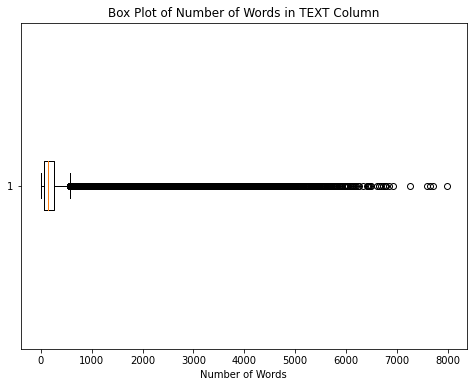

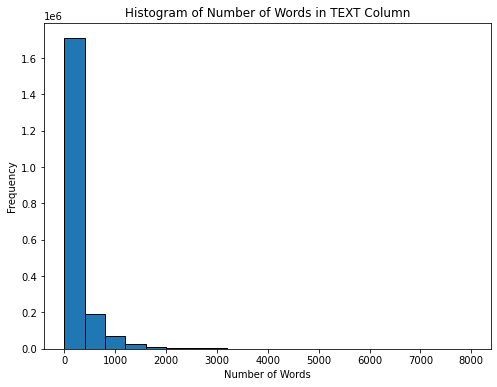

Number of null observations: 9


In [6]:
# Calculate statistics
max_words = data['W_COUNT'].max()
min_words = data['W_COUNT'].min()
avg_words = data['W_COUNT'].mean()

# Print statistics
print(f"Maximum number of words: {max_words}")
print(f"Minimum number of words: {min_words}")
print(f"Average number of words: {avg_words:.2f}")

# Create a box plot of word counts
plt.figure(figsize=(8, 6))
plt.boxplot(data['W_COUNT'], vert=False)
plt.title('Box Plot of Number of Words in TEXT Column')
plt.xlabel('Number of Words')
plt.show()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(data['W_COUNT'], bins=20, edgecolor='black')  # You can adjust the number of bins
plt.title('Histogram of Number of Words in TEXT Column')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

print("Number of null observations:", len(data[data["W_COUNT"] < 1]))

In [7]:
data = data[data["W_COUNT"] > 1]
print("Number of observations having word count less than or equal 512:",data[data["W_COUNT"] <= 512].shape[0])
print("Number of observations having word count more than 512:", data[data["W_COUNT"] > 512].shape[0])

Number of observations having word count less than or equal 512: 1794767
Number of observations having word count more than 512: 228312


In [8]:
# --- Heading counter function ---
def count_headings(dataframe, column_name='TEXT'):
    heading_counter = Counter()

    # Regular expression pattern to identify headings that end with a colon
    pattern = re.compile(r'\b[A-Za-z ]+?:')

    # Iterate through each row in the dataframe
    for text in dataframe[column_name].dropna():  # Dropping NaN values to ensure all entries are strings
        if isinstance(text, str):  # Ensure that the text is a string
            # Extract all headings using the regex pattern
            found_headings = pattern.findall(text)
            # Normalize and count each heading
            for heading in found_headings:
                normalized_heading = heading.strip()
                heading_counter[normalized_heading] += 1

    return heading_counter

In [9]:
headings = count_headings(data, column_name='TEXT')

In [10]:
# Print only headings appearing more than 10000 times, sorted by count in descending order
sorted_headings = sorted(headings.items(), key=lambda item: item[1], reverse=True)
for heading, count in sorted_headings:
    if count > 12000:
        print(f"{heading} {count}")

Reason: 629952
Plan: 527309
MEDICAL CONDITION: 499198
REASON FOR THIS EXAMINATION: 498823
Assessment: 457012
Response: 450494
Action: 448915
IMPRESSION: 443401
Admitting Diagnosis: 386765
Comments: 307366
P: 288818
INDICATION: 245672
FINDINGS: 241460
A: 213649
COMPARISON: 185148
mg Tablet Sig: 182426
CV: 179921
Allergies: 177061
Nutrition: 159282
Drains: 155895
HISTORY: 154075
Contrast: 151764
O: 151252
Communication: 144296
BP: 142137
Prophylaxis: 140187
Chief Complaint: 139758
HR: 139240
GU: 139207
GI: 138461
RR: 137813
Heart rhythm: 137692
Code status: 135381
Balance: 133701
Other labs: 132363
Height: 131211
Urine: 131082
Stool: 130475
PO: 130425
Total out: 130416
Total In: 130408
NG: 130244
Blood products: 130185
Other ICU medications: 129564
Last dose of Antibiotics: 129465
Infusions: 128993
TECHNIQUE: 128268
Tmax: 128151
ABG: 127869
Other medications: 126843
DVT: 126766
Stress ulcer: 125564
Lines: 125198
Glycemic Control: 124325
Skin: 123569
Neurologic: 122479
Delivery Device: 12

## 2. Data preprocessing

In [22]:
pdata = data.copy() # -To avoid warnings

### 2.1 Text extraction

In [23]:
# --- Define target heading variations ---
heading_variations = {
    'Admit Diagnosis': [
        'Admit diagnosis',
        'Admitting Diagnosis',
        'ADMIT DIAGNOSIS'
    ],
    'Medical Condition': [
        'MEDICAL CONDITION',
        'Medical Condition'
    ],
    'History of Present Illness': [
        'History of Present Illness',
        'HISTORY OF PRESENT ILLNESS',
        'HISTORY OF THE PRESENT ILLNESS',
        'History of the present illness',
        'HPI'
    ],
    'Chief Complaint': [
        'Chief Complaint',
        'chief complaint',
        'CHIEF COMPLAINT'
    ]
}

# Create a mapping from lowercase variants to standardized headings.
variation_to_standard = {}
for standard, variations in heading_variations.items():
    for variant in variations:
        variation_to_standard[variant.lower()] = standard

# --- Build the regex pattern using only the target headings ---
# Escape each variant and sort by length (longer ones first to avoid partial matches)
escaped_headings = sorted(
    [re.escape(variant) for variant in variation_to_standard.keys()],
    key=len,
    reverse=True
)
headings_pattern = '|'.join(escaped_headings)

# The regex stops capturing when it sees a newline followed by a line that starts with some text and a colon.
pattern = re.compile(
    rf'(?P<heading>{headings_pattern})\s*:\s*'
    rf'(?P<content>.*?)(?=\n\s*[^:\n]+:\s*|\Z)',
    re.IGNORECASE | re.DOTALL
)

In [24]:
# --- Extraction Function ---
def extract_headings(text, pattern, variation_mapping):
    """
    For each target heading in text, capture its content.
    For headings known to be one-line (such as Admitting Diagnosis), only the first line is kept.
    Also, if the captured content is empty or its first nonempty line looks like another heading,
    the value is set to None.
    """
    matches = pattern.finditer(text)
    extracted = {}
    for match in matches:
        heading_variant = match.group('heading').strip().lower()
        content = match.group('content')  # may be multiline
        content_stripped = content.strip() if content else ''
        
        # Check if the first nonempty line itself looks like a heading (e.g., "24 Hour Events:")
        first_non_empty_line = None
        for line in content.splitlines():
            if line.strip():
                first_non_empty_line = line.strip()
                break
        if first_non_empty_line and re.match(r'^[^:]+:\s*$', first_non_empty_line):
            content_stripped = ''
        if not content_stripped:
            content_stripped = None

        standard_heading = variation_mapping.get(heading_variant)
        if standard_heading:
            # Special rule: for headings expected to be one line (e.g., Admitting Diagnosis),
            # take only the first line.
            if standard_heading == "Admit Diagnosis":
                first_line = content.splitlines()[0].strip() if content else ""
                content_stripped = first_line if first_line else None

            # Merge content if the heading appears more than once.
            if standard_heading in extracted:
                if extracted[standard_heading] is None:
                    extracted[standard_heading] = content_stripped
                else:
                    if content_stripped is not None:
                        extracted[standard_heading] += " " + content_stripped
            else:
                extracted[standard_heading] = content_stripped
    return extracted

In [25]:
extract = pdata['TEXT'].apply(lambda x: extract_headings(x, pattern, variation_to_standard))
extract = pd.json_normalize(extract)
pdata = pdata.join(extract)
print(pdata.head(3))

   ROW_ID                                               TEXT  W_COUNT  \
0     174  Admission Date:  [**2151-7-16**]       Dischar...      110   
1     175  Admission Date:  [**2118-6-2**]       Discharg...     1943   
2     176  Admission Date:  [**2119-5-4**]              D...     1426   

                          History of Present Illness  \
0                                                NaN   
1  This is an 81-year-old female\nwith a history ...   
2  This 81 year old woman has a history of COPD. ...   

                                     Chief Complaint Medical Condition  \
0                                                NaN               NaN   
1                                                NaN               NaN   
2  81 yo F smoker w/ COPD, severe TBM, s/p trache...               NaN   

  Admit Diagnosis  
0             NaN  
1             NaN  
2             NaN  


In [26]:
# Combine the columns for the clinical note
clinical_columns = [
    "Chief Complaint",
    "Admit Diagnosis",
    "Medical Condition",
    "History of Present Illness"
]

# Define a function that combines text from the row and returns np.nan if the combined string is empty.
def combine_clinical_note(row):
    note = ' '.join(
        (x.strip() + ('.' if x.strip() and not x.strip().endswith('.') else ''))
        for x in row if x.strip()
    ).strip()
    return note if note else np.nan

# Fill missing values with empty strings and apply the function.
pdata['CLINICAL_NOTE'] = pdata[clinical_columns].fillna('').apply(combine_clinical_note, axis=1)

In [27]:
# Create the new df - clinicalnotes(cnotes) with the text columns
cnotes = pdata[['ROW_ID', 'TEXT', 'CLINICAL_NOTE']]
print(cnotes.head(3), "\n")
print("CLINICAL_NOTE is unique:", cnotes['CLINICAL_NOTE'].is_unique)
print("Clinical notes ROW_ID is unique:", cnotes['ROW_ID'].is_unique)

   ROW_ID                                               TEXT  \
0     174  Admission Date:  [**2151-7-16**]       Dischar...   
1     175  Admission Date:  [**2118-6-2**]       Discharg...   
2     176  Admission Date:  [**2119-5-4**]              D...   

                                       CLINICAL_NOTE  
0                                                NaN  
1  This is an 81-year-old female\nwith a history ...  
2  81 yo F smoker w/ COPD, severe TBM, s/p trache...   

CLINICAL_NOTE is unique: False
Clinical notes ROW_ID is unique: True


In [28]:
# Remove duplicates and null observations
cnotes = cnotes.drop_duplicates(subset="CLINICAL_NOTE", keep="first")
cnotes = cnotes.dropna(subset=['CLINICAL_NOTE'])
print("Clinical notes ROW_ID is unique:", cnotes['ROW_ID'].is_unique)
print("CLINICAL_NOTE is unique:", cnotes['CLINICAL_NOTE'].is_unique)
print("Number of clinical note observations:", cnotes.shape[0])

Clinical notes ROW_ID is unique: True
CLINICAL_NOTE is unique: True
Number of clinical note observations: 487335


### 2.2 Data cleaning

In [29]:
# --- Cleaner Function ---
class TextCleaner:
    def __init__(self):
        # Regex to match patterns like [** ... **], (** ... **), or ** ... ** 
        # Use a lazy quantifier (.*?) and DOTALL so we match across newlines or unusual characters.
        self.pattern = re.compile(
            r'\[\*\*.*?\*\*\]|\(\*\*.*?\*\*\)|\*\*.*?\*\*',
            flags=re.DOTALL
        )

    def remove_encodings(self, text):
        """Remove specific encoded patterns from the text."""
        return re.sub(self.pattern, '', text).strip()

    def clean_text(self, text):
        """General purpose text cleaning function, removing various patterns."""
        # 1. Remove the encoded patterns first
        text = self.remove_encodings(text)

        # 2. Remove any leftover sequences of asterisks (e.g., '****')
        text = re.sub(r'\*+', ' ', text)

        # 3. Replace multiple underscores with a single space
        text = re.sub(r'__+', ' ', text)

        # 4. Normalize whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # 5. Remove dates of the form YYYY-MM-DD
        text = re.sub(r'\d{4}-\d{1,2}-\d{1,2}', '', text)

        # 6. Remove brackets (optional, if you truly want all brackets removed)
        text = re.sub(r'[\(\)\[\]{}]', '', text)

        # 7. Remove punctuation (semicolon, colon, comma, dot, and question mark)
        # text = re.sub(r'[;,\.\?]', '', text)

        return text

    def apply_cleaning(self, dataframe, column_name='TEXT'):
        """Apply cleaning function to a DataFrame column."""
        CLEAN_TEXT = dataframe[column_name].apply(self.clean_text)
        dataframe = dataframe.assign(CLEAN_TEXT=CLEAN_TEXT)
        return dataframe

In [30]:
cleaner = TextCleaner()
cnotes = cleaner.apply_cleaning(dataframe = cnotes, column_name = "CLINICAL_NOTE")
print("CLEAN_TEXT is unique:", cnotes['CLEAN_TEXT'].is_unique)

CLEAN_TEXT is unique: False


In [31]:
cnotes = cnotes.drop_duplicates(subset="CLEAN_TEXT", keep="first")
print("CLEAN_TEXT is unique:", cnotes['CLEAN_TEXT'].is_unique)

CLEAN_TEXT is unique: True


In [32]:
text = cnotes.copy().drop(columns = {"TEXT", "CLINICAL_NOTE"})
text = text.rename(columns = {"CLEAN_TEXT": "TEXT"})

In [33]:
# --- Duplicate sentence remover function ---
def remove_duplicate_sentences(text):
    # Use regex to split text into sentences; this handles common punctuation.
    sentences = re.split(r'(?<=[.!?]) +', text)
    seen = set()
    unique_sentences = []
    for sentence in sentences:
        if sentence not in seen:
            seen.add(sentence)
            unique_sentences.append(sentence)
    return " ".join(unique_sentences)


text["TEXT"] = text["TEXT"].apply(remove_duplicate_sentences)
print("Number of observations having word count more than 512:", text[text["W_COUNT"] > 512].shape[0])

In [34]:
# --- Truncate function ---
def truncate_text_to_512(text):
    # Ensure that text is a string
    if not isinstance(text, str):
        return text
    words = text.split()
    truncated = " ".join(words[:512])
    return truncated

# Truncate input to 512 words for Bio_ClinicalBERT to match its maximum input length.
text["TEXT"] = text["TEXT"].apply(truncate_text_to_512)

In [35]:
# Count the number of words
text['W_COUNT'] = text['TEXT'].apply(lambda x: len(str(x).split()))

Maximum number of words: 512
Minimum number of words: 1
Average number of words: 34.94


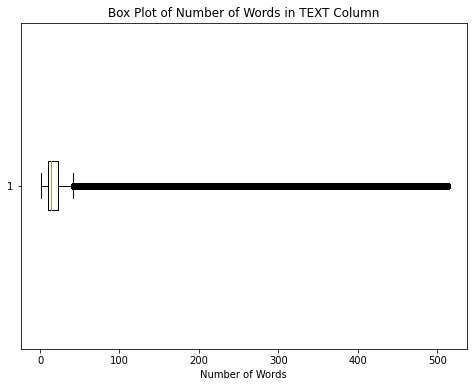

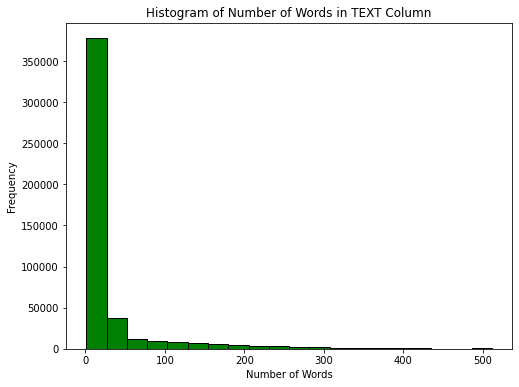

Number of null observations: 0
Number of observations having word count more than 512: 0


In [36]:
# Calculate statistics
max_words = text['W_COUNT'].max()
min_words = text['W_COUNT'].min()
avg_words = text['W_COUNT'].mean()

# Print statistics
print(f"Maximum number of words: {max_words}")
print(f"Minimum number of words: {min_words}")
print(f"Average number of words: {avg_words:.2f}")


# Create a box plot of word counts
plt.figure(figsize=(8, 6))
plt.boxplot(text['W_COUNT'], vert=False)
plt.title('Box Plot of Number of Words in TEXT Column')
plt.xlabel('Number of Words')
plt.show()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(text['W_COUNT'], bins=20, edgecolor='black', color = 'green')  # You can adjust the number of bins
plt.title('Histogram of Number of Words in TEXT Column')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

print("Number of null observations:", len(text[text["W_COUNT"] < 1]))
print("Number of observations having word count more than 512:", text[text["W_COUNT"] > 512].shape[0])

In [37]:
# text.to_csv("clinical_text.csv", index = False)

## 3. Annotation

In [43]:
text = pd.read_csv("clinical_text.csv")

### 3.1 Dr. Jim's (Domain Expert) Kinetic Trauma Regular-Expression

In [38]:
# --- Dr. Jim's (Domain Expert) vehicle regex ---
KTInj_regex = (
    r'\b(?:mva|mba|vehicle|bus|pedestrian|atv|passenger|ute|ped|bike|dirtbike|motorbike|pushbike|scooter|truck|'
    r'bicycle|motorcycle|driver|driving|rtc|rta|\d*km[a-zA-Z/]*|skateboard|surfing|surf|horse|collision|'
    r'crossing|buggy|ebike|jetski|vs car|car vs|car accident|moving car|traffic light|traffic lights|'
    r'hit by car|hit by a car|car hit|airbag|tyre|airbags|T boned)\b'
)

# Compile the regex with case-insensitive flag.
pattern = re.compile(KTInj_regex, re.IGNORECASE)

In [ ]:
# --- Prediction function using the regex ---
def predict_ka(text):
    """
    Given a text string, return a tuple (label, responsible_keywords) where:
      - label is True if any vehicle-related keyword is found, else False.
      - responsible_keywords is a comma-separated string of the matched keywords in lower case (or None if no match).
    """
    # Find all matching keywords in the text.
    matches = pattern.findall(text)
    if matches:
        # Convert each match to lower case and remove duplicates by converting to a set.
        unique_matches = list(set(match.lower() for match in matches))
        # Sort the keywords.
        unique_matches.sort()
        return True, ", ".join(unique_matches)
    else:
        return False, None

In [39]:
# Predict the labels
text[['REGEX_LABEL', 'KEY']] = text['TEXT'].apply(lambda x: pd.Series(predict_ka(x)))

In [40]:
# Subset the true cases
true = text[text["REGEX_LABEL"] == True]
true = true.sort_values(by='KEY')
print(true.head(3),"\n")
print("Total no of rows:", true.shape[0])

        ROW_ID                                               TEXT  W_COUNT  \
513847  513337  39 yoM s/p MVC vs tree, unrestrained, + airbag...       37   
893518  900774  FEMUR FX. 20 year old man with MVC, restrained...       17   
598417  605349  MVC, neck pain, back pain, knee pain, abdomina...       99   

        REGEX_LABEL     KEY  
513847         True  airbag  
893518         True  airbag  
598417         True  airbag   

Total no of rows: 10971


In [41]:
# true.to_csv("true.csv", index = False)

### 3.2 Latent Dirichlet Allocation

In [11]:
true = pd.read_csv("true.csv")

In [13]:
# --- Prediction function using the regex ---
def lda_tokenize(text):
    # Lowercase and remove non-alphabetical characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

In [15]:
true['tokens'] = true['TEXT'].apply(lda_tokenize)

In [16]:
# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(true['tokens'])
corpus = [dictionary.doc2bow(text) for text in true['tokens']]

In [17]:
# Build the LDA model
num_topics = 2
lda_model = models.LdaModel(corpus=corpus, 
                            id2word=dictionary, 
                            num_topics=num_topics, 
                            passes=1000, 
                            random_state=13)

# Print out the top words for each topic
for i, topic in lda_model.print_topics(num_words=10):
    print(f"Topic #{i}: {topic}")

Topic #0: 0.080*"sp" + 0.066*"year" + 0.066*"old" + 0.049*"vehicle" + 0.047*"motor" + 0.043*"man" + 0.041*"accident" + 0.021*"woman" + 0.017*"mvc" + 0.016*"struck"
Topic #1: 0.020*"patient" + 0.012*"pain" + 0.008*"left" + 0.007*"pt" + 0.007*"transferred" + 0.007*"found" + 0.007*"right" + 0.006*"ct" + 0.006*"chest" + 0.005*"hospital"


In [18]:
# Assign the dominant topic to each document.
def get_dominant_topic(bow):
    # Get the topic distribution for the document.
    topics = lda_model.get_document_topics(bow)
    # Select the topic with the highest probability.
    dominant_topic = sorted(topics, key=lambda x: x[1], reverse=True)[0][0]
    return dominant_topic

# Compute dominant topic for each document in the corpus.
true['dominant_topic'] = [get_dominant_topic(bow) for bow in corpus]

In [19]:
# For each topic, randomly sample and print 10 observations.
for topic in range(num_topics):
    print(f"\nRandom Observations for Topic #{topic}:")
    # Filter documents that are dominated by the current topic.
    topic_docs = true[true['dominant_topic'] == topic]
    
    # Sample 10 documents, or all if less than 10.
    sample_size = min(10, len(topic_docs))
    if sample_size == 0:
        print("No documents for this topic.")
        continue
    
    sampled = topic_docs.sample(sample_size, random_state=42)
    
    # Print the TEXT field from the sampled documents.
    for text in sampled['TEXT'].tolist():
        print(text)
        print('-'*80)


Random Observations for Topic #0:
STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES;MULTIPLE FRACTURES. 20 year old man with MVA, s/p chest tube for small pneumothorax. PTX pre d/c of chest tube.
--------------------------------------------------------------------------------
MULTIPLE TRAUMA. 32 year old man with osteogen imperfecta, s/p mva.
--------------------------------------------------------------------------------
back pain. S/P FALL;TELEMETRY. 47yM s/p fall off horse onto fence, p/w multiple injuries. 1. small Right hemo/pneumothorax 2. multiple right sided rib fractures 3. right T8-T9, L1-L5 transverse process fx, T6-T11 spinous process fx 4. Right Psoas muscle hematoma, no active extrav.
--------------------------------------------------------------------------------
s/p Motor vewhicle crash. 23 year old man with s/p MVC, intubated in ED. check placement 23 year old man s/p mvc. 23 yo male unrestrianed driver, s/p motor vehicle crash, ?LOC. Hemodynamically stable per EMS, wa